Klustring av lekplatser som ligger nära hållplatser – där varje kluster fångar ett naturligt geografiskt mönster i avståndet till kollektivtrafik. Eller snarare: “Vilka distansintervall till kollektivtrafik finns naturligt bland lekplatserna?. (Så svara ju egentligen inte helt). Kan ju jobba med på den om vi vill hämta mer info men får göra om då. Just nu fokuserar den endast på avståndet och det är de den läser in.

In [14]:
import requests 
import json
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

Gör standadiserade variabler för geografiskt området, sökväg till GTFS och overpass API-adressen (ändras alltså här om vi vill byta till annat dataset eller annat område)

In [15]:
#Geografiskt område (south, west, north, east)
bbox_s, bbox_w, bbox_n, bbox_e = 57.6, 11.9, 57.8, 12.1

#Mapp där GTFS‑filerna ligger på *din* dator
gtfs_dir = r"C:\Users\ellaa\OneDrive\Dokument\Kod\datadriven verksamhetsutveckling\Dataset KoDa\GTFS-VT-2025-04-24"

#Overpass‑API‑adress (behöver sällan ändras)
overpass_url="https://overpass-api.de/api/interpreter"

Funktion som senare kan användas för att beräkna avståndet mellan lekplatser och hållplats (kordinater). (Använder inte data i själva funktioner så kan användas på olika sätt, men då för att beräkna avstånd mellan två punkter med hjäp av longitud och latitud)

In [16]:
def haversine(coord1, coord2):
    R = 6371000  # meter
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    phi1, phi2 = map(math.radians, (lat1, lat2))
    dphi  = math.radians(lat2 - lat1)
    dlamb = math.radians(lon2 - lon1)
    a = math.sin(dphi/2)**2 + math.cos(phi1)*math.cos(phi2)*math.sin(dlamb/2)**2
    return R * 2*math.atan2(math.sqrt(a), math.sqrt(1-a))

Hämta lekplatser open street map

Filtrera området med hjälp av kordinater och exkluderar lekplatser där access = private

In [17]:
query = f"""
[out:json];
node["leisure"="playground"]({bbox_s},{bbox_w},{bbox_n},{bbox_e});
out body;
"""
resp = requests.get(overpass_url, params={"data": query})
playground = resp.json()
playground["elements"] = [
    el for el in playground["elements"]
    if el.get("tags", {}).get("access") != "private"
]

Läs in hållplatser från koda dataset som float för att kunna räkna med decimalar. 

Hämtar endast stop_lat och stop_lon från stops.txt

In [18]:
from pathlib import Path
stops_path = Path(gtfs_dir) / "stops.txt"

stops = (pd.read_csv(stops_path,
                     usecols=["stop_lat", "stop_lon"])
           .astype(float))

stops = stops[
    (bbox_s <= stops.stop_lat) & (stops.stop_lat <= bbox_n) &
    (bbox_w <= stops.stop_lon) & (stops.stop_lon <= bbox_e)
]

stops_coords = list(zip(stops.stop_lat, stops.stop_lon))

stops.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2520 entries, 1 to 22991
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   stop_lat  2520 non-null   float64
 1   stop_lon  2520 non-null   float64
dtypes: float64(2)
memory usage: 59.1 KB


Beräkna avstånd till närmsta hållplats

In [19]:
data = []
for el in playground["elements"]:
    lat, lon = el["lat"], el["lon"]
    dists = [haversine((lat, lon), sc) for sc in stops_coords]
    data.append({"lat": lat, "lon": lon, "min_distance_m": min(dists)})

df = pd.DataFrame(data)

Skapa feauture matris för att standadisera datan

In [20]:
X = df[["min_distance_m"]].values          # (n_samples, 1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

ANALYS, testa olika k (elbow + silhouette) för att hitta optimalt antal kluster

Text(0, 0.5, 'Inertia')

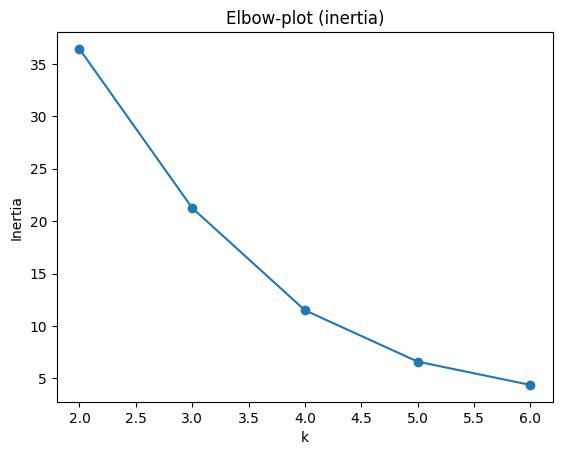

In [21]:
from sklearn.metrics import silhouette_score
inertias, sil_scores = [], []
K = range(2, 7)                            #prova k = 2–6

for k in K:
    km = KMeans(
        n_clusters=k,
        n_init="auto",         #<-- stabilare: 10 slumpstarter
        random_state=0
    )
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)                  # elbow‑värde
    sil_scores.append(silhouette_score(X_scaled, labels))

#(valfritt) plottar inertia‑kurvan
plt.figure()
plt.plot(K, inertias, marker='o')
plt.title("Elbow‑plot (inertia)")
plt.xlabel("k")
plt.ylabel("Inertia")


PRODUKTION: välj ett k (utifrån elbow) och skriv kluster‑etiketter

In [22]:
k = 4   #byt efter vad elbow/silhouette föreslår

df["cluster"] = (
    KMeans(
        n_clusters=k,
        n_init="auto",        
        random_state=0
    )
    .fit_predict(X_scaled)
)

Sammanfattning

In [23]:
summary = df.groupby("cluster")["min_distance_m"].agg(["count", "mean", "median", "min", "max"]).round(1)
print("\nAvståndsprofil per kluster (meter):\n", summary)


Avståndsprofil per kluster (meter):
          count   mean  median    min    max
cluster                                    
0           12  449.2   447.8  353.7  581.7
1           44  223.4   224.4  167.2  326.0
2           42  110.6   111.8   38.3  162.6
3            1  883.8   883.8  883.8  883.8


Visualisering

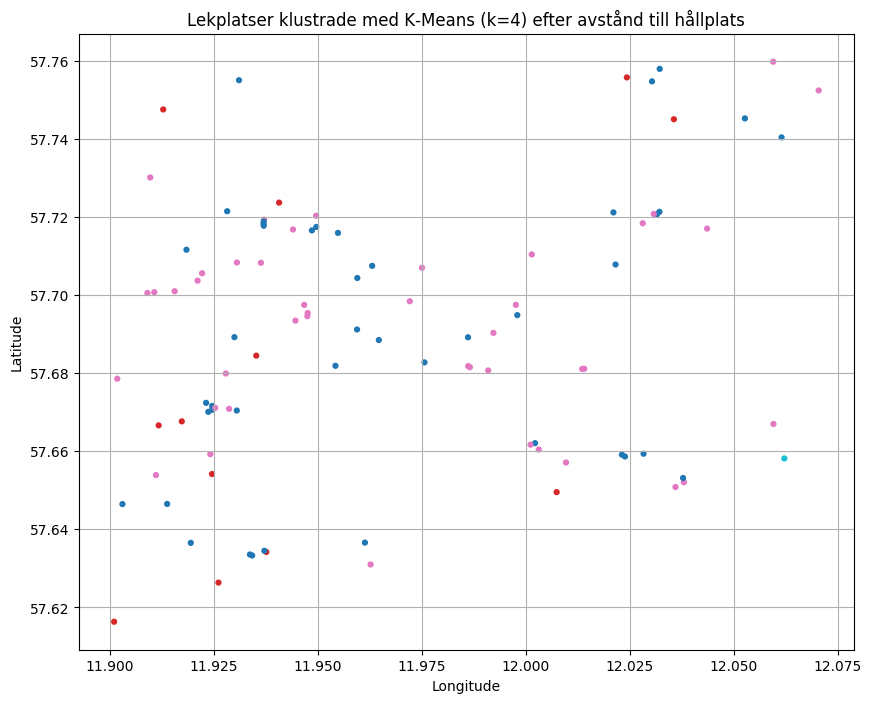

In [11]:
plt.figure(figsize=(10, 8))
plt.scatter(df.lon, df.lat, c=df.cluster, cmap="tab10", s=12)
plt.title(f"Lekplatser klustrade med K‑Means (k={k}) efter avstånd till hållplats")
plt.xlabel("Longitude"); plt.ylabel("Latitude"); plt.grid(True)
#plt.show()

Räkna antal lekplatser per kluster

In [12]:
counts = df["cluster"].value_counts().sort_index()   # Series med index = kluster‑ID

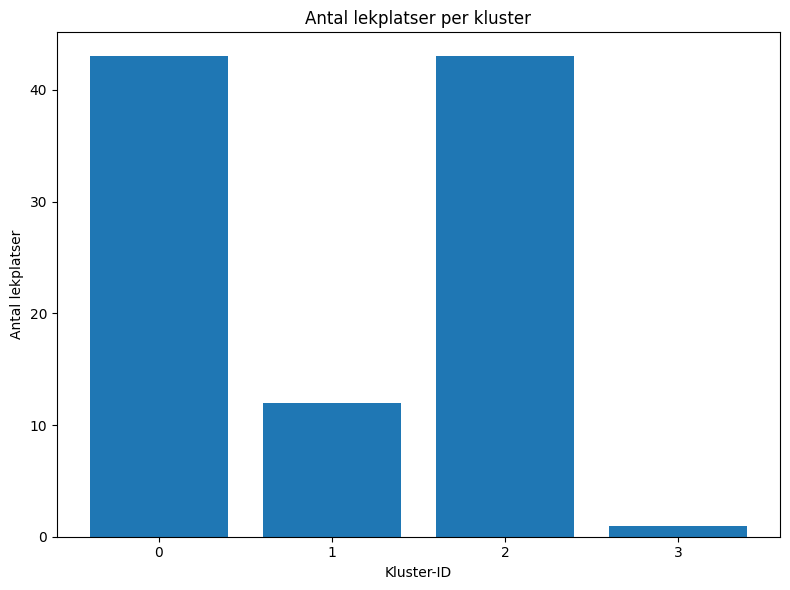

In [13]:
plt.figure(figsize=(8, 6))
plt.bar(counts.index.astype(str), counts.values)
plt.title("Antal lekplatser per kluster")
plt.xlabel("Kluster-ID")
plt.ylabel("Antal lekplatser")
plt.tight_layout()